In [114]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

DIR_PATH = '../data/suicide/'

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# /kaggle/input
for dirname, _, filenames in os.walk(DIR_PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

../data/suicide/HDI.csv
../data/suicide/master.csv
../data/suicide/postUSSR_90_00.csv
../data/suicide/postUSSR_suicide.csv


In [135]:
df = pd.read_csv(os.path.join(DIR_PATH, 'postUSSR_90_00.csv'), index_col=0)
df.head()

,country,year,sex,age,suicides_no,population,country-year,HDI,generation
0,Armenia,1990,male,35-54 years,25,332700,Armenia1990,0.632,Silent
1,Armenia,1990,male,75+ years,2,26900,Armenia1990,0.632,G.I. Generation
2,Armenia,1990,male,55-74 years,11,183800,Armenia1990,0.632,G.I. Generation
3,Armenia,1990,male,25-34 years,16,307100,Armenia1990,0.632,Boomers
4,Armenia,1990,female,35-54 years,15,358000,Armenia1990,0.632,Silent


## Общие функции
Перенес как есть из лин. регрессии

In [116]:
from sklearn.model_selection import train_test_split

def get_prepared_dataset(base_df, columns, target):
    base_df = base_df.copy()
    # выделение таргета и X
    y = base_df[target]
    X = base_df.loc[:, columns]
    
    return train_test_split(X, y, random_state=0)

train_X, val_X, train_y, val_y = get_prepared_dataset(df, ['HDI', 'sex'], 'suicides_no')
print(train_X.shape, val_X.shape, train_y.shape, val_y.shape)

(989, 2) (330, 2) (989,) (330,)


In [117]:
def get_object_cols(base_df):
    object_cols = base_df.dtypes == 'object'
    object_cols = list(object_cols[object_cols].index)
    return object_cols

columns = get_object_cols(df.loc[:, ['HDI', 'sex']])
columns

['sex']

In [118]:
from sklearn.preprocessing import OneHotEncoder

def get_OH_encoder(base_df, object_cols):
    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    OH_encoder.fit(df[object_cols])
    return OH_encoder

sub_df = df.loc[:, ['HDI', 'sex']]
object_columns = get_object_cols(sub_df)
OH_encoder = get_OH_encoder(sub_df, object_columns)
OH_encoder

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [119]:
def get_OH_encodings(OH_encoder, base_df, object_cols):
    OH_cols = pd.DataFrame(OH_encoder.transform(base_df[object_cols]))
    OH_cols.index = base_df.index # восстанавливаю индексы после энкодинга
    OH_cols.columns = OH_encoder.get_feature_names_out() # восстанавливаю наименования
    df_num_cols = base_df.drop(object_cols, axis=1)
    encoded_df = pd.concat([df_num_cols, OH_cols], axis=1)
    return encoded_df

sub_df = df.loc[:, ['HDI', 'sex']]
object_cols = get_object_cols(sub_df)
OH_encoder = get_OH_encoder(sub_df, object_columns)
train_X, val_X, _, _ = get_prepared_dataset(df, ['HDI', 'sex'], 'suicides_no')
OH_X_train, OH_X_valid = get_OH_encodings(OH_encoder, train_X, object_cols), get_OH_encodings(OH_encoder, val_X, object_cols)
print(OH_X_train.shape, OH_X_valid.shape)

(989, 3) (330, 3)


In [120]:
from sklearn.metrics import mean_absolute_error

# Для оценки МАЕ построенной лин. модели(с возможностью каста полей таргета, перед оценкой)
# TODO: заменить train_X ит.п. на словарь
def get_MAE_score(model, train_X, val_X, train_y, val_y, mae_supp_func=None):
    pred_train = model.predict(train_X)
    pred_val = model.predict(val_X)
    
    if mae_supp_func:
        train_y, val_y = mae_supp_func(train_y), mae_supp_func(val_y)
        pred_train, pred_val = mae_supp_func(pred_train), mae_supp_func(pred_val)
        
    train_MAE = mean_absolute_error(train_y, pred_train)
    val_MAE = mean_absolute_error(val_y, pred_val)
    return train_MAE, val_MAE

In [121]:
from sklearn.linear_model import LinearRegression

def get_model(base_df, columns, target, mae_supp_func=None):
    train_X, val_X, train_y, val_y = get_prepared_dataset(base_df, columns, target)
    
    object_cols = get_object_cols(train_X)
    OH_encoder = None
    if object_cols:
        OH_encoder = get_OH_encoder(base_df.loc[:, columns], object_cols)
        OH_X_train = get_OH_encodings(OH_encoder, train_X, object_cols)
        OH_X_valid = get_OH_encodings(OH_encoder, val_X, object_cols)
    else:
        OH_X_train, OH_X_valid = train_X, val_X
       
    model = LinearRegression() 
    model.fit(OH_X_train, train_y)
    
    train_MAE, val_MAE = get_MAE_score(model, OH_X_train, OH_X_valid, train_y, val_y, mae_supp_func)
    
    return model, OH_encoder, {'train': train_MAE, 'valid': val_MAE}


get_model(df, ['HDI', 'sex'], 'suicides_no')

(LinearRegression(),
 OneHotEncoder(handle_unknown='ignore', sparse=False),
 {'train': 973.6456400084264, 'valid': 863.1555526744469})

In [122]:
def get_column_comb_rating(base_df, target, mae_supp_func=None):
    # получение комбинаций(сочетаний без повторений) столбцов
    import itertools

    columns = np.array(base_df.columns)
    columns = columns[columns != target]

    columns_combinations = []
    for i in range(1, len(columns) + 1):
        columns_combinations += itertools.combinations(columns, i)
    
    # оценка каждого из сочетаний столбцов, по МАЕ
    df_column_option = []
    for option in columns_combinations:
        column_name = '|'.join(option)
        _, _, MAE = get_model(base_df, option, target, mae_supp_func)
        df_column_option.append([column_name, MAE['train'], MAE['valid']])

    df_column_option = pd.DataFrame(
        df_column_option, columns=['columns_name', 'train_MAE', 'val_MAE'])
    return df_column_option

get_column_comb_rating(df, 'suicides_no')

,columns_name,train_MAE,val_MAE
0,sex,938.162080,832.548248
1,age,918.685541,849.287879
2,population,668.941737,594.806073
3,HDI,993.197948,875.027094
4,generation,920.475717,869.466191
5,sex|age,986.607446,907.315526
6,sex|population,800.009244,736.187815
7,sex|HDI,973.645640,863.155553
8,sex|generation,980.032356,907.754545
9,age|population,704.253420,701.447775


In [123]:
def get_predictions_df(model, model_cols, OH_encoder,  req_df):
    req_X = req_df.loc[:, model_cols]
    if OH_encoder:
        object_cols = get_object_cols(req_X)
        req_X = get_OH_encodings(OH_encoder, req_X, object_cols)
        
    preds = model.predict(req_X)
    preds = pd.Series(preds, index=req_df.index, name='predictions')
    req_df['preds'] = preds
    return req_df

model_cols, target = ['HDI', 'sex'], 'suicides_no'
req_df = df.sample(n=10)
model, OH_encoder, _ = get_model(df, model_cols, target)
result_df = get_predictions_df(model, model_cols, OH_encoder, req_df)
result_df

,sex,age,suicides_no,population,HDI,generation,preds
1181,male,15-24 years,191,1955700,0.594,Generation X,-100.040586
1318,female,75+ years,6,133350,0.672,G.I. Generation,407.791666
122,male,55-74 years,14,234300,0.648,Silent,839.976362
777,female,25-34 years,13,372683,0.593,Generation X,-967.418314
343,female,35-54 years,170,1384800,0.683,Boomers,599.276600
591,male,25-34 years,879,1243300,0.679,Generation X,1379.615721
106,female,15-24 years,0,322300,0.648,Generation X,-9.993644
1223,female,5-14 years,7,2757900,0.594,Millenials,-950.010593
1082,male,55-74 years,2654,4202500,0.662,Silent,1083.684460
1136,female,25-34 years,248,3431000,0.668,Generation X,338.160781


## Собственно кластеризация

### Демо

In [124]:
from sklearn.cluster import KMeans

demo_X = df.loc[:, ['suicides_no', 'population']]
cluster_model = KMeans(n_clusters=12)
cluster_model.fit(demo_X)

KMeans(n_clusters=12)

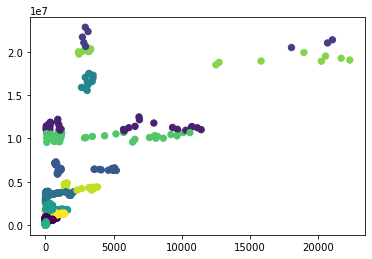

In [125]:
from matplotlib import pyplot as plt

plt.scatter(demo_X['suicides_no'], demo_X['population'], s=40, marker='o', c=cluster_model.labels_)

Это разбиение записей по группам от их количества самоубийств и населения
________
Метрика определения оптимального количества сегментов - **метрика внутрикластерного расстояния**

In [127]:
from sklearn.metrics.pairwise import euclidean_distances

cluster_inner_distances = []
demo_X = df.loc[:, ['suicides_no', 'population']]
for n_cluster in range(1, 10):
    model = KMeans(n_clusters=n_cluster)
    model.fit(demo_X)
    cluster_centers, labels = model.cluster_centers_, model.labels_
    
    total = 0
    for cluster_i in range(n_cluster):
        cluster_label_distance = euclidean_distances([cluster_centers[cluster_i]], demo_X[labels == cluster_i])
        total += cluster_label_distance.sum()
    cluster_inner_distances.append(total)
cluster_inner_distances

C:\Users\ivanv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


[3090054820.4982376,
 1471320051.3569613,
 1134222167.3239365,
 710545993.2268386,
 488954295.86432767,
 381785432.75403893,
 353463936.79641813,
 278849349.34175014,
 255530272.02619857]

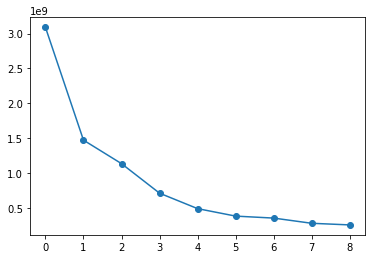

In [128]:
plt.plot(cluster_inner_distances, marker='o')

Как видно из графика, 5 секторов(если считать от 0) - оптимальное разбиение

## Итог демонстрации

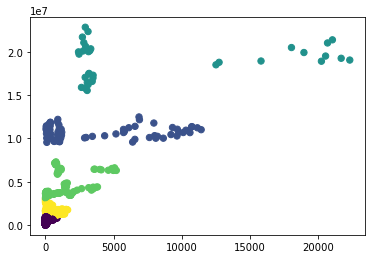

In [129]:
demo_X = df.loc[:, ['suicides_no', 'population']]
cluster_model = KMeans(n_clusters=5)
cluster_model.fit(demo_X)

plt.scatter(demo_X['suicides_no'], demo_X['population'], c=cluster_model.labels_, s=40, marker='o')

## Исследование


In [161]:
# Функция расчета метрики
def get_clusters_n_score(max_n, df_x):
    from sklearn.metrics.pairwise import euclidean_distances
    from sklearn.cluster import KMeans

    cluster_inner_distances = []
    for n_cluster in range(1, max_n):
        model = KMeans(n_clusters=n_cluster)
        model.fit(df_x)
        cluster_centers, labels = model.cluster_centers_, model.labels_
        
        total = 0
        for cluster_i in range(n_cluster):
            if df_x[labels == cluster_i].shape[0] == 0:
                print('Достигнут максимальный уровень сегментирования, при max_n = ', n_cluster - 1)
                return cluster_inner_distances
            
            cluster_label_distance = euclidean_distances([cluster_centers[cluster_i]], df_x[labels == cluster_i])
            total += cluster_label_distance.sum()
        cluster_inner_distances.append(total)
    
    return cluster_inner_distances

get_clusters_n_score(5, df.loc[:, ['suicides_no', 'population']])

C:\Users\ivanv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


[3090054820.4982376, 1471320051.3569608, 1134222167.3239365, 710545993.2268386]

In [176]:
# подготовка данных
df_X = df.loc[:, ['suicides_no', 'population']]
object_cols = get_object_cols(df_X)
encoder = get_OH_encoder(df_X, object_cols)
X = get_OH_encodings(encoder, df_X, object_cols)

C:\Users\ivanv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


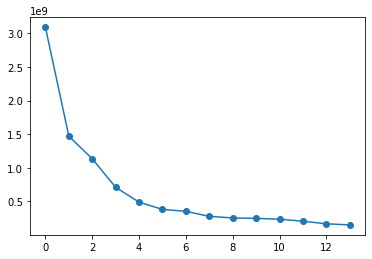

In [177]:
score = get_clusters_n_score(15, X)

plt.plot(score, marker='o')

"Локоть" образуется при 5 секторах, т.е. это оптимальное число секторов.

In [178]:
model = KMeans(n_clusters=5)
model.fit(X)

labels = model.predict(X) # хотя можно было просто model.labels_ забрать для получения ярлыков обучающего датасета

In [179]:
df['segment'] = labels
df.sample(20)

,country,year,sex,age,suicides_no,population,country-year,HDI,generation,segment
389,Belarus,2000,female,75+ years,67,331579,Belarus2000,0.683,G.I. Generation,0
584,Kazakhstan,1995,female,15-24 years,145,1412600,Kazakhstan1995,0.664,Generation X,4
288,Belarus,1992,male,35-54 years,845,1236700,Belarus1992,0.683,Boomers,4
844,Russian Federation,1995,male,15-24 years,5733,10678300,Russian Federation1995,0.824,Generation X,1
582,Kazakhstan,1995,female,55-74 years,208,1205800,Kazakhstan1995,0.664,Silent,4
748,Kyrgyzstan,1998,male,15-24 years,89,447700,Kyrgyzstan1998,0.593,Generation X,0
742,Kyrgyzstan,1997,male,5-14 years,14,587300,Kyrgyzstan1997,0.593,Millenials,0
786,Russian Federation,1990,female,55-74 years,3064,15534000,Russian Federation1990,0.824,G.I. Generation,2
574,Kazakhstan,1994,male,5-14 years,50,1784600,Kazakhstan1994,0.664,Millenials,4
354,Belarus,1997,female,55-74 years,188,1218800,Belarus1997,0.683,Silent,4


Самый интересный вариант из коробки(для данного датасета) - группировка по количеству самоубийств и населения.

Хотя, оно скорее группирует по количеству населения, ибо группировка идет по евклидовым расстояниям.

Естественно, что в паре (100, 339500) - значительно большее влияние оказывает на расчет этого расстояния число 339500, т.е. население. (Ну а количество самоубийств "подстраивается" в группировку, т.к. прямая зависимость кол-ва самоубийств от населения)

____________
В случае группировки по полу и населению, без преодобработки - пол не учитывается вообще, например.

Чтобы оно работало - нужно нормировать значения, привести их к одному порядку.  
В случае с использованием качеств. переменных - использовать нормализацию мин-макс. или любую другую нормализацию(например, сигмоиду)

И можно изменять влияние какой либо из переменных, за счет увеличения(умножения) диапазона значений этой переменной на N. (т.о. будет больше вклад в расчет евкл. расстояния, для этого алгоритма)

# Мин.макс нормализация непрерывных значений

In [184]:
def get_min_max_norm(series):
    s_min, s_max = series.min(), series.max()
    series = (series - s_min) / (s_max - s_min)
    return series

get_min_max_norm(df.suicides_no)

0       0.001119
1       0.000090
2       0.000492
3       0.000716
4       0.000672
          ...   
1315    0.000000
1316    0.000672
1317    0.001970
1318    0.000269
1319    0.000269
Name: suicides_no, Length: 1319, dtype: float64

In [199]:
df_X = df.loc[:, ['suicides_no', 'sex']]
df_X['suicides_no_min_max'] = get_min_max_norm(df_X.suicides_no) * 5
df_X = df_X.drop(columns=['suicides_no'])
object_cols = get_object_cols(df_X)
encoder = get_OH_encoder(df_X, object_cols)
X = get_OH_encodings(encoder, df_X, object_cols)
X.head()

,suicides_no_min_max,sex_female,sex_male
0,0.005596,0.0,1.0
1,0.000448,0.0,1.0
2,0.002462,0.0,1.0
3,0.003581,0.0,1.0
4,0.003358,1.0,0.0


C:\Users\ivanv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


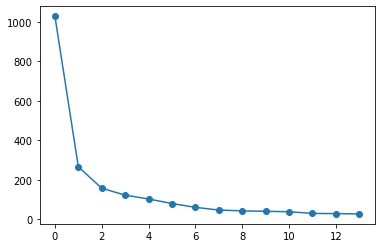

In [200]:
score = get_clusters_n_score(15, X)

plt.plot(score, marker='o')

In [203]:
model = KMeans(n_clusters=4)
model.fit(X)

labels = model.predict(X)
df['segment'] = labels
df.sample(20)

,country,year,sex,age,suicides_no,population,country-year,HDI,generation,segment
1280,Uzbekistan,1998,female,55-74 years,42,950300,Uzbekistan1998,0.594,Silent,1
385,Belarus,2000,male,35-54 years,1334,1403903,Belarus2000,0.683,Boomers,2
72,Armenia,1996,male,75+ years,3,27900,Armenia1996,0.648,G.I. Generation,2
701,Kyrgyzstan,1994,female,75+ years,8,52100,Kyrgyzstan1994,0.562,G.I. Generation,1
868,Russian Federation,1997,male,15-24 years,5780,10874000,Russian Federation1997,0.824,Generation X,0
4,Armenia,1990,female,35-54 years,15,358000,Armenia1990,0.632,Silent,1
157,Azerbaijan,1992,male,55-74 years,18,340500,Azerbaijan1992,0.609,Silent,2
260,Azerbaijan,2000,female,25-34 years,3,677500,Azerbaijan2000,0.640,Generation X,1
1104,Ukraine,1995,male,75+ years,548,575700,Ukraine1995,0.662,G.I. Generation,2
1192,Uzbekistan,1991,female,75+ years,30,216200,Uzbekistan1991,0.594,G.I. Generation,1


При применении мин-макс к количесту самоубийств - почти вся значимость при определении группы уходила на разделение по полу,
поэтому, например, при определении количества оптимальных кластеров - предлагало всего 2.

Как только я умножил значения мин-макс нормализации кол-ва суицидов на 5 - при определении опт. количества секторов - значение оптимума изменилось до 4х.  
Теперь, несмотря на все также высокую значимость различия по полу - разница в количестве самоубийств для конкр. пола - послужила причиной выделения двух записей одного пола, но с сильно отличным кол-ом самоубийств - в разные сектора.

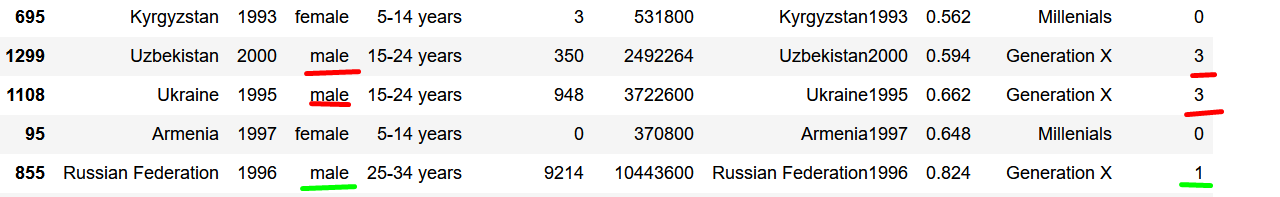

## Пробую другие алгоритмы на той же задаче: пол + самоубийства

### DBSCAN

In [220]:
from sklearn.cluster import DBSCAN

demo_X = df.loc[:, ['suicides_no', 'population']]
model = DBSCAN(eps=10e5, min_samples=10)
model.fit(demo_X)

DBSCAN(eps=1000000.0, min_samples=10)

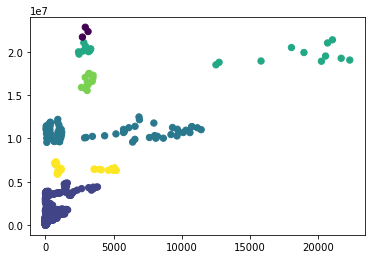

In [221]:
plt.scatter(demo_X['suicides_no'], demo_X['population'], marker='o', s=40, c=model.labels_)

eps - ставил перебором, отталкиваясь от величин населения.
____
Попробую с нормализацией по нат. логарифму, примененному к обоим величинам

In [231]:
demo_X = df.loc[:, ['suicides_no', 'population']]
for col in demo_X.columns:
    demo_X.loc[:, col] = demo_X[col].apply(lambda x: np.log(x) if x > 0 else 0)
demo_X

,suicides_no,population
0,3.218876,12.714996
1,0.693147,10.199882
2,2.397895,12.121603
3,2.772589,12.634929
4,2.708050,12.788288
...,...,...
1315,0.000000,12.937599
1316,2.708050,13.149054
1317,3.784190,12.839868
1318,1.791759,11.800733


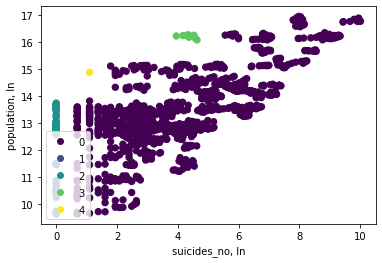

In [247]:
dbscan_model = DBSCAN(eps=0.6, min_samples=1)
dbscan_model.fit(demo_X)

scatter = plt.scatter(demo_X['suicides_no'], demo_X['population'], c=dbscan_model.labels_, s=40, marker='o')
plt.legend(*scatter.legend_elements(), loc='lower left')
plt.xlabel('suicides_no, ln'), plt.ylabel('population, ln')
plt.show()

Довольно интересный вариант получился.  
По сути, данные для разных правил оказались в разных группах.  
Данные, в которых нулевая смертность при высокой популяции - одна группа.  
В которых зависимость прямо пропорциональна и примерна равна по модулю 1 - вторая(синяя) группа.  
И последняя группа, которая при высокой популяции показывает умеренное количество самоубийств.

_____
Метрика сегментации - метрика силхуета(силуэта на с.д.). Подходит для оценки всех(мне известных) моделей сегментации.  
(Хз как применить евкл. расстояния к дбскан. да и меньше ручной работы в д.с.)  
-1 - оч. плохо и 1 - отлично  
Нужно получить как минимум 0.5

In [245]:
from sklearn.metrics import silhouette_score
score = silhouette_score(demo_X, dbscan_model.labels_)
score

-0.038746934852770365

Оценка модели сегментации выше.

In [271]:
# Функция расчета метрики
def get_dbscan_models_score(eps_options, samples_range, df_X, show_errors=False):
    from sklearn.metrics import silhouette_score
    from sklearn.cluster import DBSCAN

    cluster_score = []
    for eps in eps_options:
        for min_samples in range(samples_range[0], samples_range[1]):
            model = DBSCAN(eps=eps, min_samples=min_samples)
            model.fit(df_X)
            try:
                score = silhouette_score(df_X, model.labels_)
                cluster_score.append([eps, min_samples, score])
            except ValueError as err:
                if show_errors:
                    print(f'Ошибка для eps={eps}, min_samples={min_samples} - {err}')
    
    return pd.DataFrame(cluster_score, columns=['eps', 'min_samples', 'score'])

eps = np.linspace(0.1, 2, 50)
get_dbscan_models_score(eps, [1, 20], df.loc[:, ['suicides_no', 'population']])

,eps,min_samples,score
0,0.100000,1,0.003033
1,0.100000,2,-0.524174
2,0.138776,1,0.003033
3,0.138776,2,-0.524174
4,0.177551,1,0.003033
...,...,...,...
121,1.961224,2,-0.524680
122,1.961224,3,-0.517525
123,2.000000,1,0.008299
124,2.000000,2,-0.651553


In [272]:
eps = np.linspace(1, 3, 20)
score = get_dbscan_models_score(eps, [50, 150], demo_X)
score

,eps,min_samples,score
0,1.000000,50,0.296592
1,1.000000,51,0.296592
2,1.000000,52,0.343151
3,1.000000,53,0.343151
4,1.000000,54,0.349993
...,...,...,...
528,1.736842,145,0.477431
529,1.736842,146,0.477146
530,1.736842,147,0.477146
531,1.736842,148,0.477146


In [274]:
score.sort_values(by='score', ascending=False).head(5)

,eps,min_samples,score
528,1.736842,145,0.477431
527,1.736842,144,0.477431
526,1.736842,143,0.477431
446,1.526316,115,0.477382
436,1.526316,105,0.477382


Это лучший вариант модели, что я нашел. Лучше Dbscan для д.с. не найти

Вот, что получилось на графике

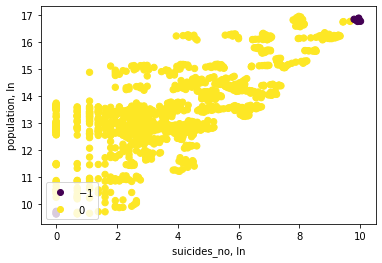

In [275]:
dbscan_model = DBSCAN(eps=1.526316, min_samples=105)
dbscan_model.fit(demo_X)

scatter = plt.scatter(demo_X['suicides_no'], demo_X['population'], c=dbscan_model.labels_, s=40, marker='o')
plt.legend(*scatter.legend_elements(), loc='lower left')
plt.xlabel('suicides_no, ln'), plt.ylabel('population, ln')
plt.show()

Мде, метрика силуэта имеет похоже крайне посредственное отношение к качеству разбиения на сегменты ._.
_________
Без применения нат. лог. к данным о:

In [294]:
eps = np.linspace(10, 10e4, 20)
X = df.loc[:, ['suicides_no', 'population']]
score = get_dbscan_models_score(eps, [2, 20], X)
score.sort_values(by=['score', 'min_samples', 'eps'], ascending=[False, True, True]).head(5)

,eps,min_samples,score
329,100000.000000,5,0.698292
311,94737.368421,5,0.696786
165,52636.315789,3,0.695173
256,78949.473684,4,0.693242
238,73686.842105,4,0.692491


Лучший скор, что я смог получить - 0.7. Визуализация того, что получило наивысшую оценку за силуэт

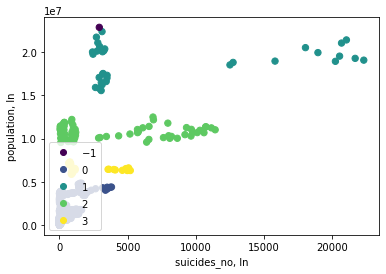

In [295]:
dbscan_model = DBSCAN(eps=10e5, min_samples=5)
dbscan_model.fit(X)

scatter = plt.scatter(df['suicides_no'], df['population'], c=dbscan_model.labels_, s=40, marker='o')
plt.legend(*scatter.legend_elements(), loc='lower left')
plt.xlabel('suicides_no, ln'), plt.ylabel('population, ln')
plt.show()

Получился результат похожий на K-means, не так уж плохо на самом деле.